In [9]:
import pprint
import random
import pandas as pd
import numpy as np
from joblib import dump, load
from scipy.sparse import load_npz, save_npz
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold

In [2]:
pp = pprint.PrettyPrinter()


Read data vectorized

In [3]:
experement_id = 0

In [4]:
data = load_npz(f'../../../local_data/data_vectorized_{experement_id}.npz')
labels_name = 'data_labels_small' if data.shape[0] <= 1_000_000 else 'data_labels'
labels = pd.read_csv(f'../../../local_data/{labels_name}.csv')['labels']
len(labels)

1000000

Train preparation

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)
print(len(y_train), len(y_test))

750000 250000


In [6]:
def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

In [17]:
def validate(params, X, Y, folds=5, repeats=5):
    fix_seed()
    cv = RepeatedKFold(n_splits=folds, n_repeats=repeats, random_state=42)
    grid = GridSearchCV(model, params, cv=cv, n_jobs=-1, scoring=['precision', 'recall'], return_train_score=True, refit='precision')
    grid.fit(X, Y)
    pp.pprint(grid.best_score_)
    pp.pprint(grid.best_params_)
    pp.pprint(grid.cv_results_)

    return grid.best_estimator_

Train model

In [18]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42, max_depth=3)

In [20]:
# repeated-cross-validation
model_best = validate({
    'max_depth': [3]
}, X_train, y_train, folds=4, repeats=1)

0.7935475518028143
{'max_depth': 3}
{'mean_fit_time': array([2.02050412]),
 'mean_score_time': array([0.13224047]),
 'mean_test_precision': array([0.79354755]),
 'mean_test_recall': array([0.98820599]),
 'mean_train_precision': array([0.79354774]),
 'mean_train_recall': array([0.9882062]),
 'param_max_depth': masked_array(data=[3],
             mask=[False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3}],
 'rank_test_precision': array([1]),
 'rank_test_recall': array([1]),
 'split0_test_precision': array([0.79315522]),
 'split0_test_recall': array([0.98815348]),
 'split0_train_precision': array([0.79367872]),
 'split0_train_recall': array([0.98822382]),
 'split1_test_precision': array([0.79284196]),
 'split1_test_recall': array([0.98784822]),
 'split1_train_precision': array([0.7937828]),
 'split1_train_recall': array([0.98832536]),
 'split2_test_precision': array([0.79351614]),
 'split2_test_recall': array([0.98826909]),
 'split2_train_precision': arra

In [21]:
# regular train
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [ ]:
# train for large data
batch_size = 10_000
for start in range(0, X_train.shape[0], batch_size):
    print(start)
    x_batch, y_batch = X_train[start: start+batch_size], y_train[start: start+batch_size]
    model.partial_fit(x_batch, y_batch, classes=[0, 1])

In [22]:
dump(model, f'../models/model_{experement_id}.sav')

['../models/model_0.sav']

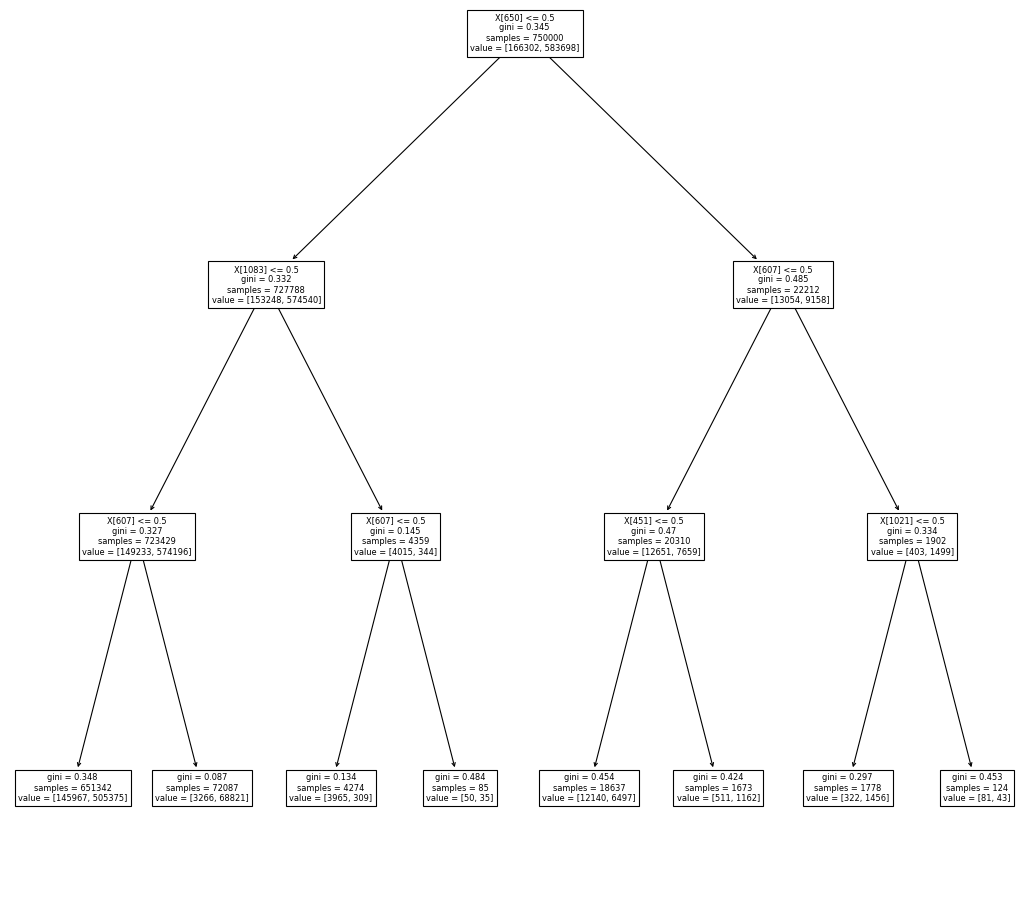

In [23]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 15), dpi=80)
plot_tree(model)
plt.show()

Evaluate model

In [47]:
# model = load(f'../models/model_{experement_id}.sav')

In [16]:
prediction_probas = model.predict_proba(X_test)
predictions = np.argmax(prediction_probas, axis=1)

In [17]:
print(f'Test sample size: {X_test.shape[0]}')
print(f'recall: {recall_score(y_test, predictions)}')
print(f'precision: {precision_score(y_test, predictions)}')
print(f'f1 score: {f1_score(y_test, predictions)}')
print(f'roc-auc: {roc_auc_score(y_test, predictions)}')

Test sample size: 250000
recall: 0.9880417845573461
precision: 0.7957357220995274
f1 score: 0.8815226562339228
roc-auc: 0.5433979868437321
